# OCT2017 - Traditional Baseline: Linear SVM

In [1]:
# ================================================
# OCT2017 - Traditional Baseline: Linear SVM
# Features: HOG + LBP(8,1) + LBP(16,2) + GLCM + intensity histogram
# Model: LinearSVC (fast, handles large datasets)
# Saves: model, metrics CSV, confusion matrix JSON, cached .npy features
# ================================================
import os, glob, time, platform, warnings, pickle, csv, json
from pathlib import PureWindowsPath
warnings.filterwarnings("ignore")

import numpy as np
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# --- Sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (classification_report, confusion_matrix,
                             accuracy_score, f1_score, roc_auc_score)

# --- Skimage features
from skimage.feature import hog, local_binary_pattern, graycomatrix, graycoprops

In [2]:

# -------------------------------
# WSL-safe path helper
# -------------------------------
def is_wsl():
    try:
        return ("microsoft" in platform.release().lower()) or ("wsl" in platform.version().lower())
    except Exception:
        return False

def win_to_wsl_path(win_path: str) -> str:
    if not is_wsl(): return win_path
    if ":" not in win_path: return win_path
    p = PureWindowsPath(win_path)
    drive = str(p.drive).replace(":", "").lower()
    tail = str(p).replace("\\", "/").split(":/")[-1]
    return f"/mnt/{drive}/{tail}"


In [3]:

# -------------------------------
# Config
# -------------------------------
BASE_DIR = r"C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15"
BASE_DIR = win_to_wsl_path(BASE_DIR)

IMG_SIZE      = (128, 128)
CLASSES       = ["CNV","DME","DRUSEN","NORMAL"]
RANDOM_SEED   = 42
OUT_DIR       = "traditional_svm"
CACHE_DIR     = os.path.join(OUT_DIR, "cache")
os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(CACHE_DIR, exist_ok=True)

SAVE_FEATURES     = True
LOAD_IF_AVAILABLE = True

USE_PCA   = True
PCA_DIMS  = 256   # reduce dimensionality, speeds up SVM

In [4]:


# -------------------------------
# Feature extractors
# -------------------------------
def extract_hog(img128):
    return hog(img128,
               pixels_per_cell=(16,16),
               cells_per_block=(2,2),
               orientations=9,
               block_norm="L2-Hys",
               transform_sqrt=True,
               feature_vector=True).astype(np.float32)

def extract_lbp_hist(img128, P=8, R=1):
    lbp = local_binary_pattern(img128, P=P, R=R, method="uniform")
    n_bins = int(P + 2)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
    return hist.astype(np.float32)

def extract_glcm_stats(img128):
    img8 = cv2.normalize(img128, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    imgQ = (img8 // 8).astype(np.uint8)  # 0..31
    distances = [1, 2, 4]
    angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
    glcm = graycomatrix(imgQ, distances=distances, angles=angles,
                        levels=32, symmetric=True, normed=True)
    props = ["contrast","dissimilarity","homogeneity","ASM","energy","correlation"]
    feats = []
    for p in props:
        vals = graycoprops(glcm, p)
        feats.append(vals.mean()); feats.append(vals.std())
    return np.array(feats, dtype=np.float32)

def extract_intensity_hist(img128, bins=32):
    hist = cv2.calcHist([img128],[0],None,[bins],[0,256]).ravel()
    hist = hist / (hist.sum() + 1e-8)
    return hist.astype(np.float32)

def extract_features_single(gray128):
    return np.concatenate([
        extract_hog(gray128),
        extract_lbp_hist(gray128, P=8,  R=1),
        extract_lbp_hist(gray128, P=16, R=2),
        extract_glcm_stats(gray128),
        extract_intensity_hist(gray128, bins=32),
    ], axis=0)


In [5]:

# -------------------------------
# Data loading + cache
# -------------------------------
def list_images(root):
    items = []
    for c in CLASSES:
        p = os.path.join(root, c)
        exts = ("*.jpg","*.jpeg","*.png","*.bmp","*.tif","*.tiff")
        files = []
        for e in exts: files += glob.glob(os.path.join(p, e))
        for f in files: items.append((f, c))
    return items

def load_split(phase_dir, cache_prefix):
    X_path = os.path.join(CACHE_DIR, f"{cache_prefix}_X.npy")
    y_path = os.path.join(CACHE_DIR, f"{cache_prefix}_y.npy")

    if LOAD_IF_AVAILABLE and os.path.isfile(X_path) and os.path.isfile(y_path):
        return np.load(X_path), np.load(y_path), []

    pairs = list_images(phase_dir)
    X, y = [], []
    for fp, label in tqdm(pairs, desc=f"Loading {phase_dir}", total=len(pairs)):
        img = cv2.imread(fp, cv2.IMREAD_GRAYSCALE)
        if img is None: continue
        img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
        X.append(extract_features_single(img))
        y.append(CLASSES.index(label))

    X = np.vstack(X).astype(np.float32)
    y = np.array(y, dtype=np.int64)

    if SAVE_FEATURES:
        np.save(X_path, X); np.save(y_path, y)
    return X, y, []


In [6]:

# -------------------------------
# Load data
# -------------------------------
train_dir = os.path.join(BASE_DIR, "train")
val_dir   = os.path.join(BASE_DIR, "val")
test_dir  = os.path.join(BASE_DIR, "test")

X_train, y_train, _ = load_split(train_dir, "train")
X_val,   y_val,   _ = load_split(val_dir,   "val")
X_test,  y_test,  _ = load_split(test_dir,  "test")

X_tr = np.vstack([X_train, X_val])
y_tr = np.concatenate([y_train, y_val])

print(f"[INFO] Train+Val {X_tr.shape}, Test {X_test.shape}")

Loading C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15\train: 100%|██████████| 59126/59126 [12:35<00:00, 78.29it/s]
Loading C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15\val: 100%|██████████| 12670/12670 [03:15<00:00, 64.74it/s]
Loading C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\dataset\OCT2017_70_15_15\test: 100%|██████████| 12669/12669 [03:28<00:00, 60.74it/s]


[INFO] Train+Val (71796, 1836), Test (12669, 1836)


In [7]:


# -------------------------------
# Build SVM pipeline
# -------------------------------
steps = [("scaler", StandardScaler())]
if USE_PCA:
    steps.append(("pca", PCA(n_components=PCA_DIMS, svd_solver="randomized", random_state=RANDOM_SEED)))

# LinearSVC does not give probabilities → wrap with CalibratedClassifierCV
base_svm = LinearSVC(class_weight="balanced", random_state=RANDOM_SEED, max_iter=5000)
svm_pipe = Pipeline(steps + [("svm", base_svm)])
svm_clf  = CalibratedClassifierCV(svm_pipe, method="sigmoid", cv=3)

# -------------------------------
# Train
# -------------------------------
print("\n==== Training Linear SVM ====")
t1 = time.time()
svm_clf.fit(X_tr, y_tr)
train_time = time.time() - t1
print(f"[INFO] Training time: {train_time:.1f}s")


==== Training Linear SVM ====
[INFO] Training time: 54.5s


In [8]:


# -------------------------------
# Evaluate
# -------------------------------
y_pred = svm_clf.predict(X_test)
acc    = accuracy_score(y_test, y_pred)
f1m    = f1_score(y_test, y_pred, average="macro")
print(f"\n[RESULT] Test Acc={acc:.4f} | Macro-F1={f1m:.4f}")
print("\nClassification report:\n", classification_report(y_test, y_pred, target_names=CLASSES, digits=4))

cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# ROC-AUC
y_bin   = label_binarize(y_test, classes=np.arange(len(CLASSES)))
y_score = svm_clf.predict_proba(X_test)
auc_ovr = roc_auc_score(y_bin, y_score, multi_class="ovr")
print(f"ROC-AUC (OvR): {auc_ovr:.4f}")






[RESULT] Test Acc=0.7870 | Macro-F1=0.6479

Classification report:
               precision    recall  f1-score   support

         CNV     0.8206    0.9405    0.8765      5617
         DME     0.7914    0.5848    0.6726      1739
      DRUSEN     0.6307    0.1452    0.2361      1329
      NORMAL     0.7496    0.8730    0.8066      3984

    accuracy                         0.7870     12669
   macro avg     0.7481    0.6359    0.6479     12669
weighted avg     0.7743    0.7870    0.7593     12669

Confusion matrix:
 [[5283   44   55  235]
 [ 302 1017   14  406]
 [ 603   12  193  521]
 [ 250  212   44 3478]]
ROC-AUC (OvR): 0.9153


In [9]:
# ================================================
# Plot Confusion Matrix for SVM
# ================================================


CLASSES = ["CNV","DME","DRUSEN","NORMAL"]

# Path to saved confusion matrix
cm_path = "traditional_svm/svm_confusion_matrix.json"

# Load
with open(cm_path, "r") as f:
    cm = np.array(json.load(f))

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES,
            cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - Linear SVM")
plt.tight_layout()
plt.show()

# -------------------------------
# Save Normalized Confusion Matrix Plot
# -------------------------------
cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize row-wise

plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=CLASSES, yticklabels=CLASSES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Normalized Confusion Matrix (SVM)")
plt.tight_layout()

cm_norm_plot_path = os.path.join(OUT_DIR, "svm_confusion_matrix_normalized.png")
plt.savefig(cm_norm_plot_path, dpi=300)
plt.close()
print(f"[SAVED] {cm_norm_plot_path}")

FileNotFoundError: [Errno 2] No such file or directory: 'traditional_svm/svm_confusion_matrix.json'

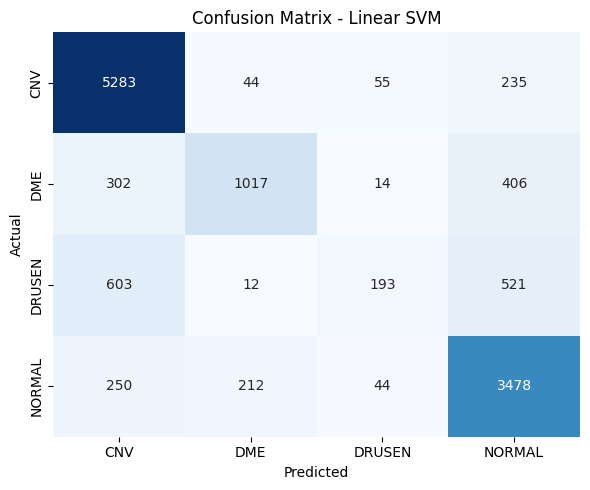

In [ ]:

# -------------------------------
# Output directory (your path)
# -------------------------------
OUT_DIR = r"C:\Users\sheno\OneDrive\CODCSD201F-006-SetupFile\Desktop\FINAL\models"
os.makedirs(OUT_DIR, exist_ok=True)

# -------------------------------
# Save model
# -------------------------------
model_path = os.path.join(OUT_DIR, "linear_svm.pkl")
with open(model_path, "wb") as f:
    pickle.dump(svm_clf, f)

# Save confusion matrix values
with open(os.path.join(OUT_DIR, "svm_confusion_matrix.json"), "w") as f:
    json.dump(cm.tolist(), f, indent=2)

# Save metrics
metrics_path = os.path.join(OUT_DIR, "svm_metrics.csv")
with open(metrics_path, "w", newline="") as f:
    w = csv.writer(f)
    w.writerow(["metric","value"])
    w.writerow(["test_accuracy", f"{acc:.6f}"])
    w.writerow(["test_f1_macro", f"{f1m:.6f}"])
    w.writerow(["train_time_sec", f"{train_time:.3f}"])
    w.writerow(["roc_auc_ovr", f"{auc_ovr:.6f}"])
print(f"[SAVED] {model_path}, {metrics_path}")
